## Example 08 - Multiple vessels

### Imports
Import the required libraries

In [1]:
import opentnsim
print('This notebook has been tested with OpenTNSim version {}'.format(opentnsim.__version__))

This notebook has been tested with OpenTNSim version 1.0.0


In [2]:
# package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry

# package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# OpenTNSIM
import opentnsim.core as core
import opentnsim.graph_module as graph_module
import opentnsim.plot as plot

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

In [3]:
# Graph location
selection = 1

if selection==1:
    # graph of Amsterdam Canals
    location_graph = "Shape-Files/Amsterdam-Canals"
    name_graph = "final_network_v4.shp"

elif selection ==2:
    # graph of Rotterdam-Antwerp transport corridor
    location_graph = "Shape-Files/Rotterdam-Antwerpen-corridor"
    name_graph = "edges_2.shp"
        
elif selection ==3:
    # graph of all waterways in the Netherlands
    location_graph = "Shape-Files/Vaarwegvakken"
    name_graph = "Vaarwegvakken.shp"

elif selection ==4:
    # NB: not a navigable graph, rather a shapefile containing km marks
    location_graph = "Shape-Files/Kilometermarkeringen"
    name_graph = "kmmarkeringen.shp"

In [4]:
# print graph that is selected
print(location_graph)
print(name_graph)

Shape-Files/Amsterdam-Canals
final_network_v4.shp


### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda)):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

In [5]:
graph = graph_module.Graph()
graph.from_shape(location_graph, name_graph)

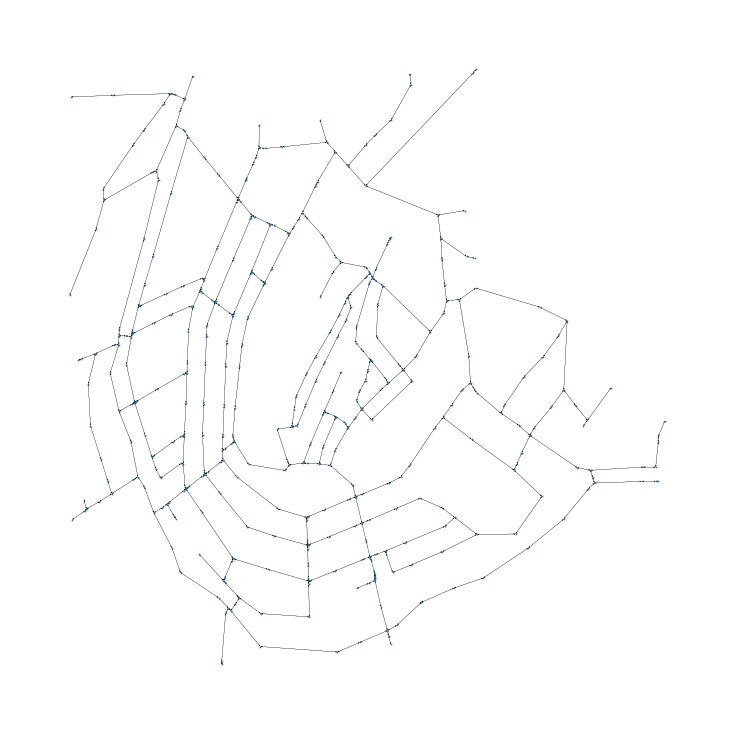

In [6]:
graph.create_graph_new_projection()
graph.plot()

### Make vessels and paths

In [7]:
# number of vessels to generate
nr_of_vessels = 30

In [8]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.ContainerDependentMovable, 
                          core.HasResource, core.Routeable), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel",
               "route": None,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

vessels = []
for i in range(nr_of_vessels):
    vessel = TransportResource(**data_vessel)
    vessel.name = "Vessel " + str(i + 1)
    vessels.append(vessel)

In [9]:
paths = []
for i in range(nr_of_vessels):
    random_1 = random.choice(list(graph.graph))
    random_2 = random.choice(list(graph.graph))
    
    path = nx.dijkstra_path(graph.graph, random_1, random_2)
    
    paths.append(path)

### Start simulation

In [10]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
        if vessel.geometry == nx.get_node_attributes(env.FG, "geometry")[vessel.route[-1]]:
            break

In [11]:
# Start simpy environment
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = graph.graph

for i, vessel in enumerate(vessels):
    # Add environment and path to the vessel
    vessel.env = env
    vessel.route = paths[i]
    vessel.geometry = nx.get_node_attributes(graph.graph, "geometry")[paths[i][0]]

    # Add the movements of the vessel to the simulation
    env.process(start(env, vessel))

env.epoch = datetime.datetime.now()

env.run()

### Obtain vessel log information
The cel below uses the vessel log. The core function *log_entry* is used, which takes four arguments:

- **Log.** A text to describe what is logged.
- **t.** The timestamp.
- **Value.**  The value for the log (for sailing this is the distance).
- **Geometry** The location of the vessel while loggin.

In [12]:
vessel_log = pd.DataFrame.from_dict(vessels[0].log)
vessel_log.head()

,Message,Timestamp,Value,Geometry
0,Start sailing,2020-05-08 14:53:50.000000,,POINT (4.881073301169948 52.38571330459273)
1,"Sailing from node (4.881073, 52.385713) to nod...",2020-05-08 14:53:50.000000,0,POINT (4.881073301169948 52.38571330459273)
2,"Sailing from node (4.881073, 52.385713) to nod...",2020-05-08 14:54:20.518878,0,POINT (4.881516806100665 52.38567355019411)
3,"Sailing from node (4.881517, 52.385674) to nod...",2020-05-08 14:54:20.518878,0,POINT (4.881516806100665 52.38567355019411)
4,"Sailing from node (4.881517, 52.385674) to nod...",2020-05-08 14:55:40.514225,0,POINT (4.882623001415389 52.38543130371907)


### Visualization of path
If you get an error regarding ffmpeg use [this](https://stackoverflow.com/questions/13316397/matplotlib-animation-no-moviewriters-available) answer. You have to install ffmpeg in your Conda environment. It can be done using the following command.

```bash
#Install ffmpeg using Conda
conda install -c conda-forge ffmpeg
```

In [13]:
# visualise vessel movements based on the information included in the vessel.log
plot.vessel_kml(env, vessels, stepsize = 60)
plot.graph_kml(env)

In [14]:
# open the file
if platform.system():
    !start ./graph.kml
    !start ./vessel_movements.kml
    
else:
    !start explorer ./graph.kml
    !start explorer ./vessel_movements.kml
